<a href="https://colab.research.google.com/github/dlfvn/ZD/blob/main/Tiled_ZoeDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an adapted version of https://colab.research.google.com/github/isl-org/ZoeDepth/blob/main/notebooks/ZoeDepth_quickstart.ipynb

Corresponding paper : [ZoeDepth: Zero-shot Transfer by Combining Relative and Metric Depth](https://arxiv.org/abs/2302.12288v1)

Here, higher resolution depth maps are generated from the following process:

1.   Generate a depth map for the overall image
2.   Split original image into overlapping tiles
3.   Generate depth maps for the tiles
4.   Reassemble into a single depth map by applying gradient masks and average weighting from first depth map
5.   Repeat steps 2-4 at higher resolution
6.   Combine all three depth maps by:
  *   Calculate edge filter from original RGB image
  *   Blur edge filter and use as mask for high resolution depth map
  *   Apply masked high resolution to average of low and medium resolution depth maps

It is possible to use BYOD to replace step 6:
https://github.com/compphoto/BoostYourOwnDepth

However, it currently leads to banding:
https://github.com/compphoto/BoostingMonocularDepth/issues/62

<br>

**Output:** <br>
Low resolution (normal ZoeDepth) output is created as:
/content/ZoeDepth/zoe_depth_map_16bit_low.png

High resolution combined output is created as:
/content/ZoeDepth/combined_image.png

# Setup (takes ~1 minute)

In [ ]:
!pip install --upgrade timm==0.6.7

In [ ]:
!git clone https://github.com/isl-org/ZoeDepth.git
%cd ZoeDepth
!python sanity.py

import torch
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image
import matplotlib.pyplot as plt

zoe = torch.hub.load(".", "ZoeD_N", source="local", pretrained=True)

zoe = zoe.to('cuda')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.2 MB/s eta 0:00:00
Cloning into 'ZoeDepth'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 111 (delta 41), reused 96 (delta 32), pack-reused 0
Receiving objects: 100% (111/111), 4.09 MiB | 3.96 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/ZoeDepth
/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or help(..., trust_repo=

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


# Image selection

In [ ]:
# from the web
# img_url = "http://static1.squarespace.com/static/6213c340453c3f502425776e/62f2452bc121595f4d87c713/62f3c63c5eec2b12a333f851/1661442296756/Screenshot+2022-08-10+at+15.55.27.png?format=1500w"
img_url = "https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Motorcycle-perfect/ambientBall/L2/im0e0.png"
img = get_image_from_url(img_url)

# from drive
# from google.colab import drive
# drive.mount('/content/drive')
# img = Image.open('/content/drive/MyDrive/DSC_0001.JPG')


# High resolution tiling

### Generate low resolution depth map

In [ ]:
import numpy as np

low_res_depth = zoe.infer_pil(img)
low_res_scaled_depth = 2**16 - (low_res_depth - np.min(low_res_depth)) * 2**16 / (np.max(low_res_depth) - np.min(low_res_depth))

low_res_depth_map_image = Image.fromarray((0.999 * low_res_scaled_depth).astype("uint16"))
low_res_depth_map_image.save('zoe_depth_map_16bit_low.png')

### Generate filters to mask overlapping tiles

In [ ]:
# store filters in lists

im = np.asarray(img)

tile_sizes = [[4,4], [8,8]]

filters = []

save_filter_images = True

for tile_size in tile_sizes:

    num_x = tile_size[0]
    num_y = tile_size[1]

    M = im.shape[0]//num_x
    N = im.shape[1]//num_y

    filter_dict = {}
    filter_dict['right_filter'] = np.zeros((M, N))
    filter_dict['left_filter'] = np.zeros((M, N))
    filter_dict['top_filter'] = np.zeros((M, N))
    filter_dict['bottom_filter'] = np.zeros((M, N))
    filter_dict['top_right_filter'] = np.zeros((M, N))
    filter_dict['top_left_filter'] = np.zeros((M, N))
    filter_dict['bottom_right_filter'] = np.zeros((M, N))
    filter_dict['bottom_left_filter'] = np.zeros((M, N))
    filter_dict['filter'] = np.zeros((M, N))

    # left_filter = np.zeros((M, N))
    # top_filter = np.zeros((M, N))
    # bottom_filter = np.zeros((M, N))

    # top_right_filter = np.zeros((M, N))
    # top_left_filter = np.zeros((M, N))
    # bottom_right_filter = np.zeros((M, N))
    # bottom_left_filter = np.zeros((M, N))

    # filter = np.zeros((M, N))

    for i in range(M):
      for j in range(N):
          x_value = 0.998*np.cos((abs(M/2-i)/M)*np.pi)**2
          y_value = 0.998*np.cos((abs(N/2-j)/N)*np.pi)**2

          if j > N/2:
              filter_dict['right_filter'][i,j] = x_value
          else:
              filter_dict['right_filter'][i,j] = x_value * y_value

          if j < N/2:
              filter_dict['left_filter'][i,j] = x_value
          else:
              filter_dict['left_filter'][i,j] = x_value * y_value

          if i < M/2:
              filter_dict['top_filter'][i,j] = y_value
          else:
              filter_dict['top_filter'][i,j] = x_value * y_value

          if i > M/2:
              filter_dict['bottom_filter'][i,j] = y_value
          else:
              filter_dict['bottom_filter'][i,j] = x_value * y_value

          if j > N/2 and i < M/2:
              filter_dict['top_right_filter'][i,j] = 0.998
          elif j > N/2:
              filter_dict['top_right_filter'][i,j] = x_value
          elif i < M/2:
              filter_dict['top_right_filter'][i,j] = y_value
          else:
              filter_dict['top_right_filter'][i,j] = x_value * y_value

          if j < N/2 and i < M/2:
              filter_dict['top_left_filter'][i,j] = 0.998
          elif j < N/2:
              filter_dict['top_left_filter'][i,j] = x_value
          elif i < M/2:
              filter_dict['top_left_filter'][i,j] = y_value
          else:
              filter_dict['top_left_filter'][i,j] = x_value * y_value

          if j > N/2 and i > M/2:
              filter_dict['bottom_right_filter'][i,j] = 0.998
          elif j > N/2:
              filter_dict['bottom_right_filter'][i,j] = x_value
          elif i > M/2:
              filter_dict['bottom_right_filter'][i,j] = y_value
          else:
              filter_dict['bottom_right_filter'][i,j] = x_value * y_value

          if j < N/2 and i > M/2:
              filter_dict['bottom_left_filter'][i,j] = 0.998
          elif j < N/2:
              filter_dict['bottom_left_filter'][i,j] = x_value
          elif i > M/2:
              filter_dict['bottom_left_filter'][i,j] = y_value
          else:
              filter_dict['bottom_left_filter'][i,j] = x_value * y_value

          filter_dict['filter'][i,j] = x_value * y_value

    filters.append(filter_dict)

    if save_filter_images:
        for filter in list(filter_dict.keys()):
            filter_image = Image.fromarray((filter_dict[filter]*2**16).astype("uint16"))
            filter_image.save(f'mask_{filter}_{num_x}_{num_y}.png')

In [ ]:
compiled_tiles_list = []

for i in range(len(filters)):

    num_x = tile_sizes[i][0]
    num_y = tile_sizes[i][1]

    M = im.shape[0]//num_x
    N = im.shape[1]//num_y

    compiled_tiles = np.zeros((im.shape[0], im.shape[1]))

    x_coords = list(range(0,im.shape[0],im.shape[0]//num_x))[:num_x]
    y_coords = list(range(0,im.shape[1],im.shape[1]//num_y))[:num_y]

    x_coords_between = list(range((im.shape[0]//num_x)//2, im.shape[0], im.shape[0]//num_x))[:num_x-1]
    y_coords_between = list(range((im.shape[1]//num_y)//2,im.shape[1],im.shape[1]//num_y))[:num_y-1]

    x_coords_all = x_coords + x_coords_between
    y_coords_all = y_coords + y_coords_between

    for x in x_coords_all:
        for y in y_coords_all:

            depth = zoe.infer_pil(Image.fromarray(np.uint8(im[x:x+M,y:y+N])))

            scaled_depth = 2**16 - (depth - np.min(depth)) * 2**16 / (np.max(depth) - np.min(depth))

            if y == min(y_coords_all) and x == min(x_coords_all):
                selected_filter = filters[i]['top_left_filter']
            elif y == min(y_coords_all) and x == max(x_coords_all):
                selected_filter = filters[i]['bottom_left_filter']
            elif y == max(y_coords_all) and x == min(x_coords_all):
                selected_filter = filters[i]['top_right_filter']
            elif y == max(y_coords_all) and x == max(x_coords_all):
                selected_filter = filters[i]['bottom_right_filter']
            elif y == min(y_coords_all):
                selected_filter = filters[i]['left_filter']
            elif y == max(y_coords_all):
                selected_filter = filters[i]['right_filter']
            elif x == min(x_coords_all):
                selected_filter = filters[i]['top_filter']
            elif x == max(x_coords_all):
                selected_filter = filters[i]['bottom_filter']
            else:
                selected_filter = filters[i]['filter']

            compiled_tiles[x:x+M, y:y+N] += selected_filter * (np.mean(low_res_scaled_depth[x:x+M, y:y+N]) + np.std(low_res_scaled_depth[x:x+M, y:y+N]) * ((scaled_depth - np.mean(scaled_depth)) /  np.std(scaled_depth)))

    compiled_tiles[compiled_tiles < 0] = 0
    compiled_tiles_list.append(compiled_tiles)

    tiled_depth_map = Image.fromarray((2**16 * 0.999 * compiled_tiles / np.max(compiled_tiles)).astype("uint16"))
    tiled_depth_map.save(f'tiled_depth_{i}.png')


### Combine depth maps

In [ ]:
from scipy.ndimage import gaussian_filter

grey_im = np.mean(im,axis=2)

tiles_blur = gaussian_filter(grey_im, sigma=20)
tiles_difference = tiles_blur - grey_im

# np.clip(tiles_difference, 0,  np.max(tiles_difference))

tiles_difference = tiles_difference / np.max(tiles_difference)

tiles_difference = gaussian_filter(tiles_difference, sigma=40)

tiles_difference *= 5

tiles_difference = np.clip(tiles_difference, 0, 0.999)

mask_image = Image.fromarray((tiles_difference*2**16).astype("uint16"))
mask_image.save('mask_image.png')

combined_result = (tiles_difference * compiled_tiles_list[1] + (1-tiles_difference) * ((compiled_tiles_list[0] + low_res_scaled_depth)/2))/(2)

combined_image = Image.fromarray((2**16 * 0.999* combined_result / np.max(combined_result)).astype("uint16"))
combined_image.save('combined_image.png')


# Display output images

Original low resolution result


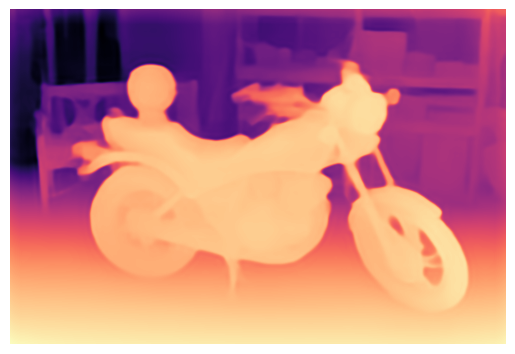


New high resolution result


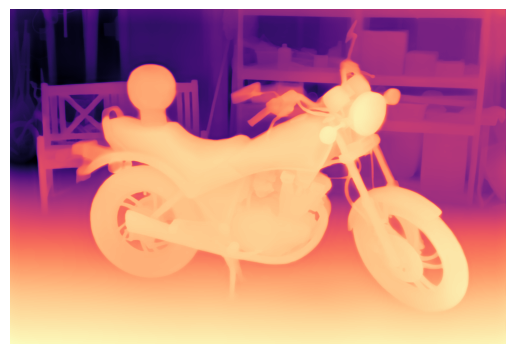

In [ ]:
print('Original low resolution result')
plt.imshow(low_res_scaled_depth, 'magma')
plt.axis("off")
plt.show()

print('\nNew high resolution result')
plt.imshow(combined_result, 'magma')
plt.axis("off")
plt.show()